In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *


import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-06T13:26:54.998


In [4]:
only_MST_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

In [5]:
only_MST_array.table.units = "deg"
only_MST_array.table
only_MST_array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,22.65
2,0.0,151.0,25.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.67
3,0.0,-151.0,31.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.68
4,150.0,75.0,21.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,188.09
5,150.0,-75.0,26.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,187.98
6,150.0,240.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.50
7,150.0,-240.0,30.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.49
8,313.0,0.0,19.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,335.47


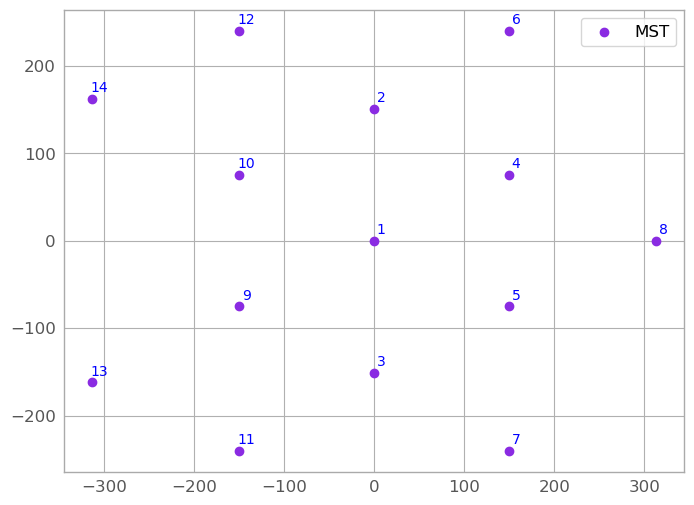

In [6]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in only_MST_array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(only_MST_array.table)):
    plt.scatter(only_MST_array.table['x'][i], only_MST_array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(only_MST_array.table["id"][i]),
                 (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

In [25]:
sub_groups={'1':[7,8,11], 
            '2': [5,13,16,18],
            '3': [14,15,17], 
            '4': [6,10,12,9]}
sub_groups_2 = {'1':[18,17,16,14], 
                '2': [13,15,5,7],
                '3': [6,8,10],
                '4': [9,11,12]
              }
#sub_groups_2={'1':[18,14,13,17],
#             '2':[7,11,15],
#             '3':[5,8,9,12],
#            '4':[16,6,10]}


second_best={'1':[16,18,13], 
            '2': [14,17,15],
            '3': [5,6,10,9], 
            '4': [7,8,11,12]}
overposition = {'1':[18,10,12,13], 
                '2':[14,15,17],
                '3': [6,7,9,11],
                '4': [16,8,5]
              }
sub_groups_3={'1':[16,9,17],
             '2':[10,14,18],
             '3':[6,8,7,12],
             '4':[13,5,11,15]}
sub_groups_4={'1':[16,9,17],
             '2':[10,14,18,12],
             '3':[6,8,7],
             '4':[13,5,11,15]}
def adjust_values(dictionary, adjustment=-4):
    return {key: [value + adjustment for value in values] for key, values in dictionary.items()}

# Apply adjustment to all dictionaries
sub_groups = adjust_values(sub_groups)
sub_groups_2 = adjust_values(sub_groups_2)
second_best = adjust_values(second_best)
overposition = adjust_values(overposition)
sub_groups_3 = adjust_values(sub_groups_3)
sub_groups_4 = adjust_values(sub_groups_4)

# Print results
print("sub_groups:", sub_groups)
print("sub_groups_2:", sub_groups_2)
print("second_best:", second_best)
print("overposition:", overposition)
print("sub_groups_3:", sub_groups_3)
print("sub_groups_4:", sub_groups_4)

sub_groups: {'1': [3, 4, 7], '2': [1, 9, 12, 14], '3': [10, 11, 13], '4': [2, 6, 8, 5]}
sub_groups_2: {'1': [14, 13, 12, 10], '2': [9, 11, 1, 3], '3': [2, 4, 6], '4': [5, 7, 8]}
second_best: {'1': [12, 14, 9], '2': [10, 13, 11], '3': [1, 2, 6, 5], '4': [3, 4, 7, 8]}
overposition: {'1': [14, 6, 8, 9], '2': [10, 11, 13], '3': [2, 3, 5, 7], '4': [12, 4, 1]}
sub_groups_3: {'1': [12, 5, 13], '2': [6, 10, 14], '3': [2, 4, 3, 8], '4': [9, 1, 7, 11]}
sub_groups_4: {'1': [12, 5, 13], '2': [6, 10, 14, 8], '3': [2, 4, 3], '4': [9, 1, 7, 11]}


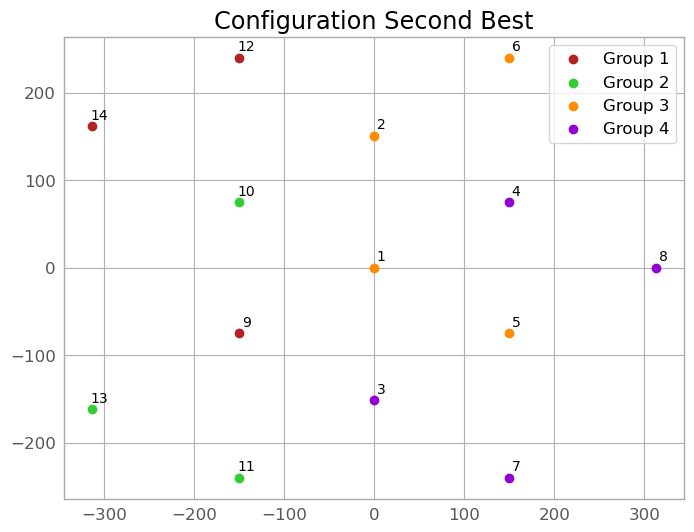

In [27]:
# Define colors for each subgroup
sub_group_colors = {
    '1': 'firebrick',
    '2': 'limegreen',
    '3': 'darkorange',
    '4': 'darkviolet'
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in second_best.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors[id_to_subgroup.get(only_MST_array.table["id"][i], '4')]  # Default to subgroup '4' if not found
    for i in range(len(only_MST_array.table))
]

# Scatter plot for all points
for i in range(len(only_MST_array.table)):
    plt.scatter(
        only_MST_array.table['x'][i], 
        only_MST_array.table['y'][i], 
        c=colors[i], 
        label=f"Group {id_to_subgroup[only_MST_array.table['id'][i]]}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_MST_array.table["id"][i]),
        (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
by_label=dict(sorted(by_label.items()))
plt.legend(by_label.values(), by_label.keys())
plt.legend(by_label.values(), by_label.keys())
plt.title("Configuration Second Best")
plt.show()

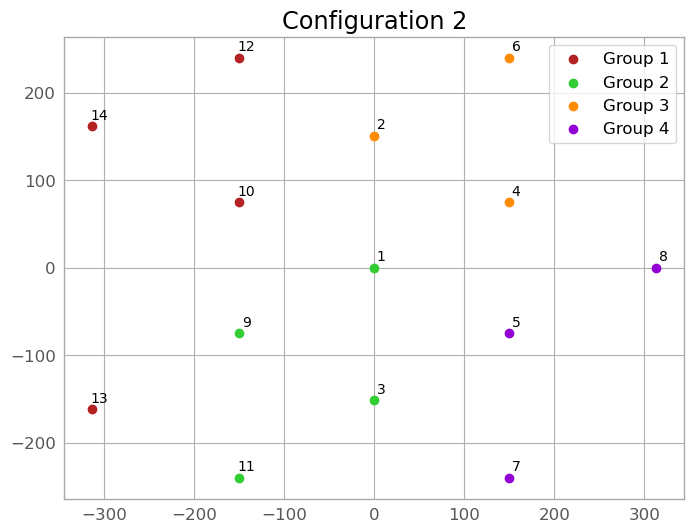

In [23]:
# Define colors for each subgroup
sub_group_colors = {
    '1': 'firebrick',
    '2': 'limegreen',
    '3': 'darkorange',
    '4': 'darkviolet'
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in sub_groups_2.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors[id_to_subgroup.get(only_MST_array.table["id"][i], '4')]  # Default to subgroup '4' if not found
    for i in range(len(only_MST_array.table))
]

# Scatter plot for all points
for i in range(len(only_MST_array.table)):
    plt.scatter(
        only_MST_array.table['x'][i], 
        only_MST_array.table['y'][i], 
        c=colors[i], 
        label=f"Group {id_to_subgroup[only_MST_array.table['id'][i]]}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_MST_array.table["id"][i]),
        (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels, make a dictionary 
dict(sorted(by_label.items())) #Like this to sort 1,2,3,4 how you wrote at the top
by_label=dict(sorted(by_label.items()))
plt.legend(by_label.values(), by_label.keys())
plt.title("Configuration 2")
plt.show()

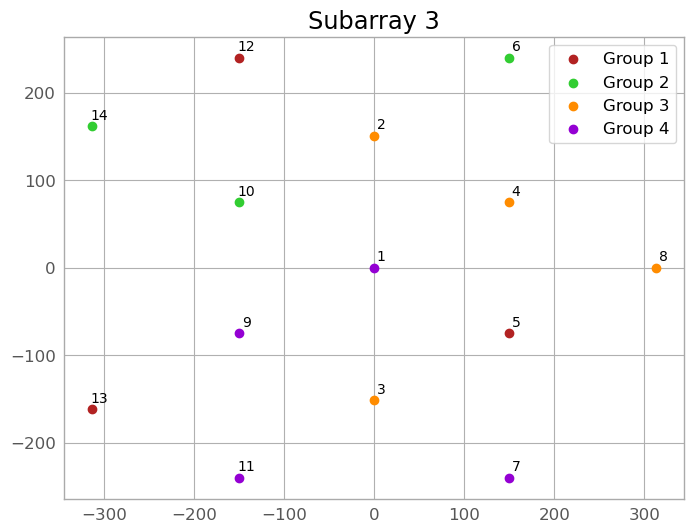

In [28]:
# Define colors for each subgroup
sub_group_colors = {
    '1': 'firebrick',
    '2': 'limegreen',
    '3': 'darkorange',
    '4': 'darkviolet'
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in sub_groups_3.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors[id_to_subgroup.get(only_MST_array.table["id"][i], '4')]  # Default to subgroup '4' if not found
    for i in range(len(only_MST_array.table))
]

# Scatter plot for all points
for i in range(len(only_MST_array.table)):
    plt.scatter(
        only_MST_array.table['x'][i], 
        only_MST_array.table['y'][i], 
        c=colors[i], 
        label=f"Group {id_to_subgroup[only_MST_array.table['id'][i]]}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_MST_array.table["id"][i]),
        (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
by_label=dict(sorted(by_label.items()))
plt.legend(by_label.values(), by_label.keys())
plt.legend(by_label.values(), by_label.keys())
plt.title("Subarray 3")
plt.show()

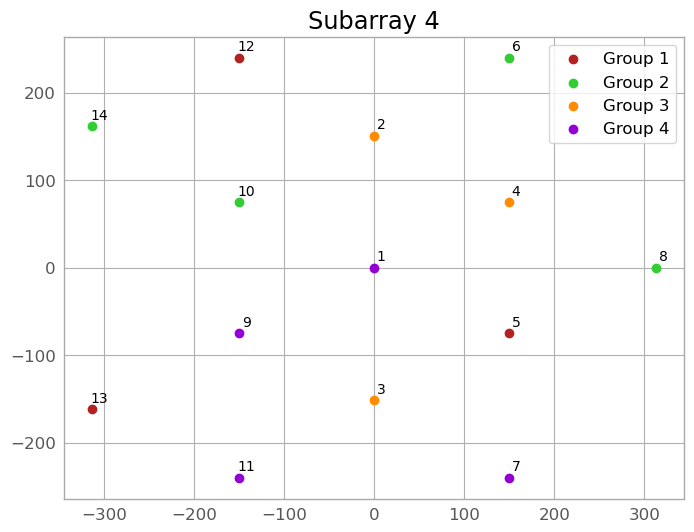

In [29]:
# Define colors for each subgroup
#This doesnt work as we can see the telescopes were too sparse 
sub_group_colors = {
    '1': 'firebrick',
    '2': 'limegreen',
    '3': 'darkorange',
    '4': 'darkviolet'
}

# Create a dictionary mapping telescope IDs to their subgroup
id_to_subgroup = {}
for group, ids in sub_groups_4.items():
    for telescope_id in ids:
        id_to_subgroup[telescope_id] = group

# Assign a color to each telescope based on its subgroup
colors = [
    sub_group_colors[id_to_subgroup.get(only_MST_array.table["id"][i], '4')]  # Default to subgroup '4' if not found
    for i in range(len(only_MST_array.table))
]

# Scatter plot for all points
for i in range(len(only_MST_array.table)):
    plt.scatter(
        only_MST_array.table['x'][i], 
        only_MST_array.table['y'][i], 
        c=colors[i], 
        label=f"Group {id_to_subgroup[only_MST_array.table['id'][i]]}"
    )
    # Annotate each point with the telescope ID
    plt.annotate(
        str(only_MST_array.table["id"][i]),
        (only_MST_array.table['x'][i], only_MST_array.table['y'][i]),  # Point position
        textcoords="offset points",  # Text position relative to the point
        xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
        ha='center', fontsize=10, color='black'
    )

# Add a legend for the subgroups
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
by_label=dict(sorted(by_label.items()))
plt.legend(by_label.values(), by_label.keys())
plt.legend(by_label.values(), by_label.keys())
plt.title("Subarray 4")
plt.show()